# Regression and Other Stories: Introclass

Plot residuals vs. predicted values, or residuals vs. observed values? See Chapter 11 in Regression and Other Stories.

---

### Load Packages

In [1]:
using CSV, HTTP, DataFrames, Turing, Distributions, MCMCChains, StatsPlots;

### Load data

In [2]:
url = "https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Introclass/data/gradesW4315.dat"
introclass = CSV.File(
    IOBuffer(
        replace(
            HTTP.get(url).body, 
            UInt8('\t') => UInt8(' ') # Mixed spaces and tabs in file
        )
    ),
    delim=" ", 
    ignorerepeated=true
    ) |> DataFrame
first(introclass, 6)

,hw1,hw2,hw3,hw4,midterm,hw5,hw6,hw7,final
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,95,88,100,95,80,96,99,0,103
2,0,74,74,0,53,83,97,0,79
3,100,0,105,100,91,96,100,96,122
4,0,90,76,100,63,91,95,0,78
5,100,96,99,100,91,93,100,92,135
6,90,83,95,100,73,89,100,90,117


## Linear regression model

In [3]:
@model function LinearRegression(midterm, final)
    α ~ TruncatedNormal(70, 20, 0, 150)
    β ~ Normal(0, 10)
    σ ~ Exponential(10)
    final ~ MvNormal(α .+ midterm * β , σ)
end;

In [4]:
lr_model = LinearRegression(introclass.midterm, introclass.final)
fit_1 = sample(lr_model, NUTS(100, 0.65), 5000)
summarystats(fit_1)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /Users/tburch/.julia/packages/Turing/uAz

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat 
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64 

           α   66.0345   13.3932     0.1894    0.4328    868.0071    1.0000
           β    0.6845    0.1704     0.0024    0.0054    884.3754    1.0000
           σ   14.8795    1.4756     0.0209    0.0299   2741.2792    1.0005


### Compute residuals 

compute predictions from simulations

In [5]:
sims=predict(LinearRegression(introclass.midterm, missing), fit_1);
predicted = vec(mean(Array(group(sims, :final)); dims=1))
resid = introclass.final - predicted;

### Plot residuals vs predicted

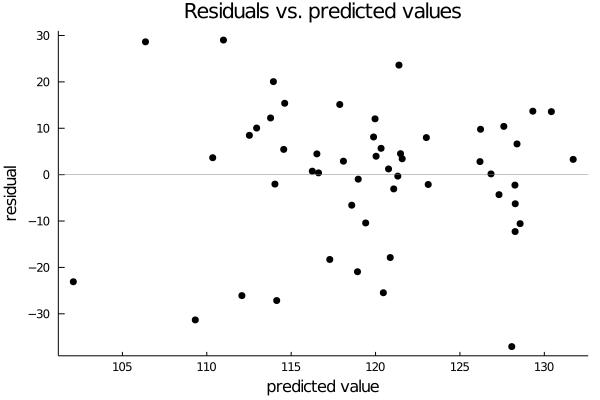

In [6]:
scatter(
    predicted, 
    resid, 
    legend=false, 
    grid=false, 
    color=:black,
    xlabel="predicted value",
    ylabel="residual",
    title="Residuals vs. predicted values"
    )
hline!([0], color=:gray, linewidth=0.5)

### Plot residuals vs observed

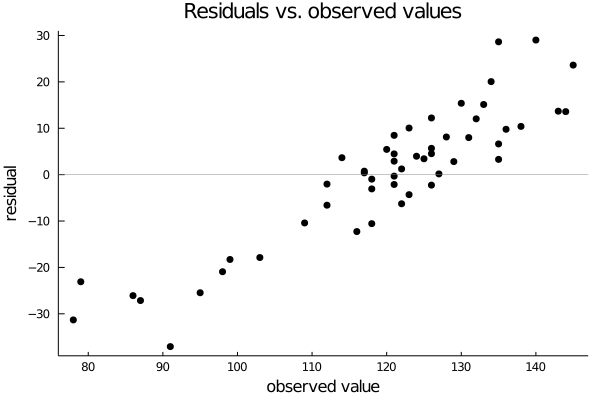

In [7]:
scatter(
    introclass.final, 
    resid, 
    legend=false, 
    grid=false, 
    color=:black,
    xlabel="observed value",
    ylabel="residual",
    title="Residuals vs. observed values"
    )
hline!([0], color=:gray, linewidth=0.5)

## Simulated fake data

In [8]:
a = 65
b = 0.7
sigma = 15
n = nrow(introclass)
introclass[:,"final_fake"] = a .+ b * introclass[:,"midterm"] .+ rand(Normal(0, 15), n)
fake_model = LinearRegression(introclass.midterm, introclass.final_fake)
fit_fake = sample(fake_model, NUTS(100, 0.65), 2000);

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/tburch/.julia/packages/AdvancedHMC/MIxdK/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.000390625
└ @ Turing.Inference /Users/tburch/.julia/packages/Turing/uAz5c/src/inference/hmc.jl:195
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


### Compute residuals

compute predictions from simulations

In [9]:
sims=predict(LinearRegression(introclass.midterm, missing), fit_fake);
predicted_fake = vec(mean(Array(group(sims, :final)); dims=1))
resid_fake = introclass.final_fake - predicted;

### Plot residuals vs predicted

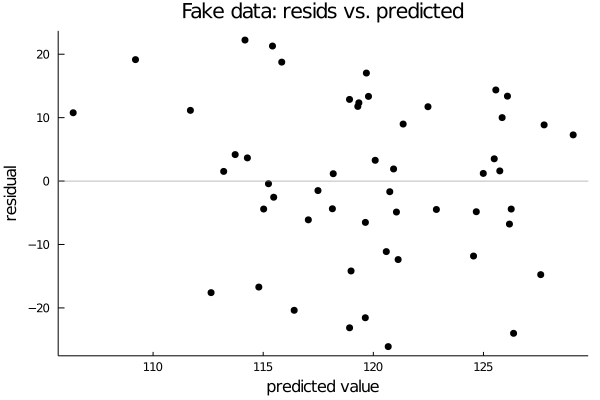

In [10]:
scatter(
    predicted_fake, 
    resid_fake, 
    legend=false, 
    grid=false, 
    color=:black,
    xlabel="predicted value",
    ylabel="residual",
    title="Fake data: resids vs. predicted"
    )
hline!([0], color=:gray, linewidth=0.5)

### Plot residuals vs observed

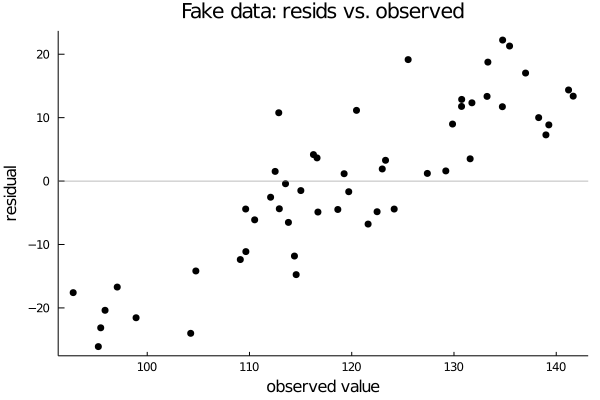

In [11]:
scatter(
    introclass.final_fake, 
    resid_fake, 
    legend=false, 
    grid=false, 
    color=:black,
    xlabel="observed value",
    ylabel="residual",
    title="Fake data: resids vs. observed"
    )
hline!([0], color=:gray, linewidth=0.5)